In [1]:
import pandas as pd
from mp_api.client import MPRester
import csv
import os
import pickle
import multiprocessing as multi
from tqdm.auto import tqdm
from pymatgen.core import Composition

/home/lc/Conda_envs/MPRester/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<font size="8">Mechanical Properties<font> 

<font size="6">Prepare training and prediction datasets for ML<font> 

In [8]:
elements_list = ["Li", "Na", "K"]
with MPRester("8Gz6ZHndNpXJ19RAl8KJMiiaxIB9k10j") as mpr:
    with open('../Data/train_data_K_G.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['material_id', 'formula_pretty', 'composition', 'K_vrh', 'G_vrh'])

        for elem in elements_list:
            docs = mpr.materials.summary.search(
                elements=[elem],
                fields=["material_id", "formula_pretty", "composition", "bulk_modulus", "shear_modulus"]
            )

            for doc in docs:
                mpid = doc.material_id
                formula = doc.formula_pretty
                composition = doc.composition
                bulk_modulus = doc.bulk_modulus['vrh'] if doc.bulk_modulus and 'vrh' in doc.bulk_modulus else None
                shear_modulus = doc.shear_modulus['vrh'] if doc.shear_modulus and 'vrh' in doc.shear_modulus else None

                if bulk_modulus is not None and shear_modulus is not None:
                    csvwriter.writerow([mpid, formula, composition, bulk_modulus, shear_modulus])

Retrieving SummaryDoc documents: 100%|████| 8012/8012 [00:02<00:00, 3190.09it/s]


In [22]:
train_df = pd.read_csv('../Data/train_data_K_G.csv')
train_df = train_df.drop(['formula_pretty', 'G_vrh'], axis = 1)
train_df.to_csv('../Data/train_data_K.csv',index=False) 
train_df

,material_id,composition,K_vrh
0,mp-755646,Li2 Cu2 O2,28.615
1,mp-975321,Li2 Si6,40.544
2,mp-16648,Li2 Sn8 Rh2,63.729
3,mp-14209,Li3 Y3 Ge3,59.504
4,mp-33322,Li2 Ho2 Se4,46.754
...,...,...,...
1667,mp-973535,K3 Sc1,23.710
1668,mp-982664,K3 In1,6.456
1669,mp-7897,K6 P2,13.975
1670,mp-23697,K3 Al1 H6,18.623


In [23]:
train_df = pd.read_csv('../Data/train_data_K_G.csv')
train_df = train_df.drop(['formula_pretty', 'K_vrh'], axis = 1)
train_df.to_csv('../Data/train_data_G.csv',index=False) 
train_df

,material_id,composition,G_vrh
0,mp-755646,Li2 Cu2 O2,17.231
1,mp-975321,Li2 Si6,1.582
2,mp-16648,Li2 Sn8 Rh2,40.822
3,mp-14209,Li3 Y3 Ge3,46.996
4,mp-33322,Li2 Ho2 Se4,31.404
...,...,...,...
1667,mp-973535,K3 Sc1,1.210
1668,mp-982664,K3 In1,3.082
1669,mp-7897,K6 P2,6.039
1670,mp-23697,K3 Al1 H6,-53.670


In [20]:
df = pd.read_csv('../Data/7_APs_with screened_Eg.csv')
prediction_df = pd.DataFrame(columns=['material_id','composition','K_vrh'])
prediction_df['material_id'] = df.index
prediction_df['composition'] = df['composition']
prediction_df['K_vrh']=0
prediction_df.to_csv('../Data/prediction_data_K.csv',index=False) 
prediction_df

,material_id,composition,K_vrh
0,0,Li3 H0.75 I0.625 N0.375 O1,0
1,1,Li3 H1 I0.5 N0.5 O1,0
2,2,Li3 H1.25 I0.375 N0.625 O1,0
3,3,Li3 H1.5 I0.25 N0.75 O1,0
4,4,Li3 H1.75 I0.125 N0.875 O1,0
...,...,...,...
4568,4568,K2 H2.25 N1 O1.75,0
4569,4569,K2 H2 N1 O2,0
4570,4570,K2 H1.75 N1 O2.25,0
4571,4571,K2 H1.5 N1 O2.5,0


In [21]:
df = pd.read_csv('../Data/7_APs_with screened_Eg.csv')
prediction_df = pd.DataFrame(columns=['material_id','composition','G_vrh'])
prediction_df['material_id'] = df.index
prediction_df['composition'] = df['composition']
prediction_df['G_vrh']=0
prediction_df.to_csv('../Data/prediction_data_G.csv',index=False) 
prediction_df

,material_id,composition,G_vrh
0,0,Li3 H0.75 I0.625 N0.375 O1,0
1,1,Li3 H1 I0.5 N0.5 O1,0
2,2,Li3 H1.25 I0.375 N0.625 O1,0
3,3,Li3 H1.5 I0.25 N0.75 O1,0
4,4,Li3 H1.75 I0.125 N0.875 O1,0
...,...,...,...
4568,4568,K2 H2.25 N1 O1.75,0
4569,4569,K2 H2 N1 O2,0
4570,4570,K2 H1.75 N1 O2.25,0
4571,4571,K2 H1.5 N1 O2.5,0


<font size="6">Machine Learning (ROOST)<font>

Command:  

cd ROOST

python roost-example.py --train --evaluate --data-path ../Data/train_data_K.csv --test-path ../Data/prediction_data_K.csv  --tasks regression --targets K_vrh --losses L1 --robust --epochs 100 --ensemble 10  

python roost-example.py --train --evaluate --data-path ../Data/train_data_G.csv --test-path ../Data/prediction_data_G.csv  --tasks regression --targets G_vrh --losses L1 --robust --epochs 100 --ensemble 10  

In [2]:
df = pd.read_csv('../ROOST/results/K_prediction_results.csv')
result_df = df.drop(['K_vrh_ale_n0', 'K_vrh_ale_n1', 'K_vrh_ale_n2', 'K_vrh_ale_n3', 'K_vrh_ale_n4', 'K_vrh_ale_n5', 'K_vrh_ale_n6', 'K_vrh_ale_n7', 'K_vrh_ale_n8', 'K_vrh_ale_n9'], axis = 1)
result_ensemble_mean_K = result_df.iloc[:,:2].rename(columns={'target':'ensemble_mean'})
result_ensemble_mean_K['K'] = [result_df.iloc[i,2:].mean() for i in tqdm(range(len(result_df)))]
result_ensemble_mean_K

100%|█████████████████████████████████████| 4573/4573 [00:00<00:00, 9060.70it/s]


,material_id,composition,K
0,0,Li3 H0.75 I0.625 N0.375 O1,35.970075
1,1,Li3 H1 I0.5 N0.5 O1,38.315044
2,2,Li3 H1.25 I0.375 N0.625 O1,40.258012
3,3,Li3 H1.5 I0.25 N0.75 O1,41.688354
4,4,Li3 H1.75 I0.125 N0.875 O1,42.818083
...,...,...,...
4568,4568,K2 H2.25 N1 O1.75,19.790025
4569,4569,K2 H2 N1 O2,20.644775
4570,4570,K2 H1.75 N1 O2.25,21.487118
4571,4571,K2 H1.5 N1 O2.5,22.311586


In [3]:
df = pd.read_csv('../ROOST/results/G_prediction_results.csv')
result_df = df.drop(['G_vrh_ale_n0', 'G_vrh_ale_n1', 'G_vrh_ale_n2', 'G_vrh_ale_n3', 'G_vrh_ale_n4', 'G_vrh_ale_n5', 'G_vrh_ale_n6', 'G_vrh_ale_n7', 'G_vrh_ale_n8', 'G_vrh_ale_n9'], axis = 1)
result_ensemble_mean_G = result_df.iloc[:,:2].rename(columns={'target':'ensemble_mean'})
result_ensemble_mean_G['G'] = [result_df.iloc[i,2:].mean() for i in tqdm(range(len(result_df)))]
result_ensemble_mean_G

100%|█████████████████████████████████████| 4573/4573 [00:00<00:00, 9053.96it/s]


,material_id,composition,G
0,0,Li3 H0.75 I0.625 N0.375 O1,18.634893
1,1,Li3 H1 I0.5 N0.5 O1,19.945919
2,2,Li3 H1.25 I0.375 N0.625 O1,21.259497
3,3,Li3 H1.5 I0.25 N0.75 O1,22.172661
4,4,Li3 H1.75 I0.125 N0.875 O1,22.336786
...,...,...,...
4568,4568,K2 H2.25 N1 O1.75,8.101849
4569,4569,K2 H2 N1 O2,8.289945
4570,4570,K2 H1.75 N1 O2.25,8.516657
4571,4571,K2 H1.5 N1 O2.5,8.783453


In [4]:
merged_df = pd.merge(result_ensemble_mean_K, result_ensemble_mean_G, how='inner')
merged_df.to_csv('../Data/8_APs_with_K_G_prediction_results.csv',index=False)
merged_df

,material_id,composition,K,G
0,0,Li3 H0.75 I0.625 N0.375 O1,35.970075,18.634893
1,1,Li3 H1 I0.5 N0.5 O1,38.315044,19.945919
2,2,Li3 H1.25 I0.375 N0.625 O1,40.258012,21.259497
3,3,Li3 H1.5 I0.25 N0.75 O1,41.688354,22.172661
4,4,Li3 H1.75 I0.125 N0.875 O1,42.818083,22.336786
...,...,...,...,...
4568,4568,K2 H2.25 N1 O1.75,19.790025,8.101849
4569,4569,K2 H2 N1 O2,20.644775,8.289945
4570,4570,K2 H1.75 N1 O2.25,21.487118,8.516657
4571,4571,K2 H1.5 N1 O2.5,22.311586,8.783453


In [5]:
screened_df_1 = merged_df[(merged_df['K']>30)] 
screened_df_2 = screened_df_1[(screened_df_1['G']>17.14)] 
screened_df = screened_df_2[(screened_df_2['K'] / screened_df_2['G']>1.75)] 
screened_df.to_csv('../Data/9_APs_with_screened_K_G.csv',index=False)
screened_df

,material_id,composition,K,G
0,0,Li3 H0.75 I0.625 N0.375 O1,35.970075,18.634893
1,1,Li3 H1 I0.5 N0.5 O1,38.315044,19.945919
2,2,Li3 H1.25 I0.375 N0.625 O1,40.258012,21.259497
3,3,Li3 H1.5 I0.25 N0.75 O1,41.688354,22.172661
4,4,Li3 H1.75 I0.125 N0.875 O1,42.818083,22.336786
...,...,...,...,...
4196,4196,K2 Al0.5 H1 Cl0.5 O3 F2,34.679286,17.975538
4199,4199,K2 Al0.875 H1 Br0.125 O1 F3.5,34.054270,18.997167
4200,4200,K2 Al0.75 H1 Br0.25 O1 F3,33.359906,18.714476
4201,4201,K2 Al0.625 H1 Br0.375 O1 F2.5,31.731104,17.883865


<font size="6">Plot the Mechanical Properties Distribution<font>

In [32]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

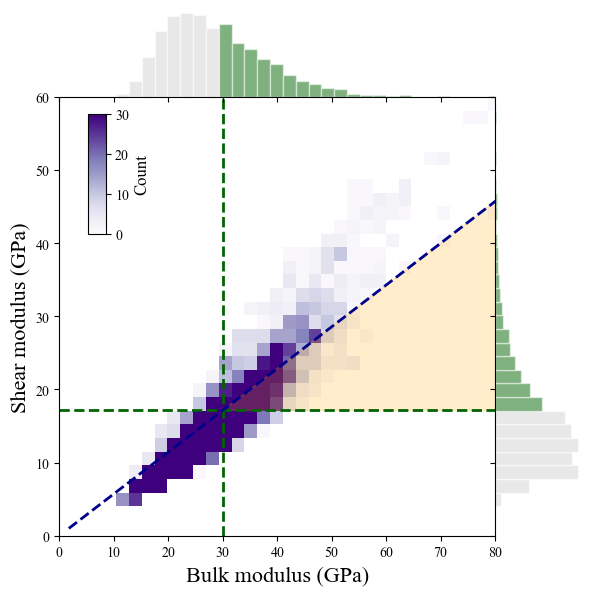

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import numpy as np

# Load the data
file_path = '../Data/8_APs_with_K_G_prediction_results.csv'
data = pd.read_csv(file_path)

# Extract data for plotting
K = data['K']
G = data['G']

# Set up the JointGrid
plt.rcParams["font.family"] = "Times New Roman"
g = sns.JointGrid(x=K, y=G, space=0, ratio=5)

# Create 2D histogram on the main axes with updated color range settings for better visibility
counts, xedges, yedges, im = g.ax_joint.hist2d(K, G, bins=30, cmap="Purples", cmin=1, vmin=0, vmax=30)  # Reduced vmax to make color distribution less extreme

# Add horizontal and vertical lines for reference
g.ax_joint.axvline(x=30.0, color='darkgreen', linestyle='--', linewidth=2, label='K = 30 GPa')
g.ax_joint.axhline(y=17.14, color='darkgreen', linestyle='--', linewidth=2, label='G = 20 GPa')

# Add the curve for x/y > 1.75 (or y = x / 1.75)
grid_y = np.linspace(1, 60, 100)
grid_x = 1.75 * grid_y
g.ax_joint.plot(grid_x, grid_y, color='darkblue', linestyle='--', linewidth=2, label='x/y > 1.75')

# Highlight the area that meets the filtering conditions (x > 30, y > 20, and x/y > 1.75)
polygon_points = [ (80, 17.14), (80, 80 / 1.75), (17.14 * 1.75, 17.14)]
polygon = patches.Polygon(polygon_points, closed=True, color='orange', alpha=0.2)
g.ax_joint.add_patch(polygon)

# Create histograms for the marginal plots with colored bins based on conditions
bins = 30

# X Marginal Histogram
n, bins_x, patches_x = g.ax_marg_x.hist(K, bins=bins, alpha=0.5, edgecolor='w')
for i in range(len(patches_x)):
    if bins_x[i] > 28:
        patches_x[i].set_facecolor('darkgreen')
    else:
        patches_x[i].set_facecolor('lightgrey')

# Y Marginal Histogram
n, bins_y, patches_y = g.ax_marg_y.hist(G, bins=bins, alpha=0.5, edgecolor='w', orientation='horizontal')
for i in range(len(patches_y)):
    if bins_y[i] > 16:
        patches_y[i].set_facecolor('darkgreen')
    else:
        patches_y[i].set_facecolor('lightgrey')

# Set axis labels
g.set_axis_labels('Bulk modulus (GPa)', 'Shear modulus (GPa)', fontsize=16)

# Add color bar with adjusted settings for visibility
cbar_ax = g.fig.add_axes([0.15, 0.60, 0.03, 0.2])
cbar = g.fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Count', fontsize=12)

# Set axis limits to focus on selected range
g.ax_joint.set_xlim(0, 80)
g.ax_joint.set_ylim(0, 60)

plt.savefig('../Figure/K_G_distribution.png')

# Show the updated figure
plt.show()